In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from colicoords import SynthCell, SynthCellList, CellPlot, CellListPlot, load, align_cells

This notebook consists of two part. The first part is how to use the cell's coordinate system to transfrom a pair of (x, y) coordinates to cell coordinates, and vice versa. The second part is how to use these transformation to align cell to combine either fluorescence images or idividual localizations (STORM/tracking).

## Coordinate transformations

We will use `SynthCell`, which is a subclass of `Cell`, and it allows the user to generate cell objects for testing and simulation purposes.  The cell object is initialized by specifing the length, radius and curvature (units are pixels):

In [2]:
cell_1 = SynthCell(50, 8, 0.005)
cp_1 = CellPlot(cell_1)

Next is to define two points to test the coordinate transformation, we have chosen one point along the midsection of the cell (blue) and one at the pole (green). 

In [3]:
p1 = (20, 3)
p2 = (70, 25)

<IPython.core.display.Javascript object>


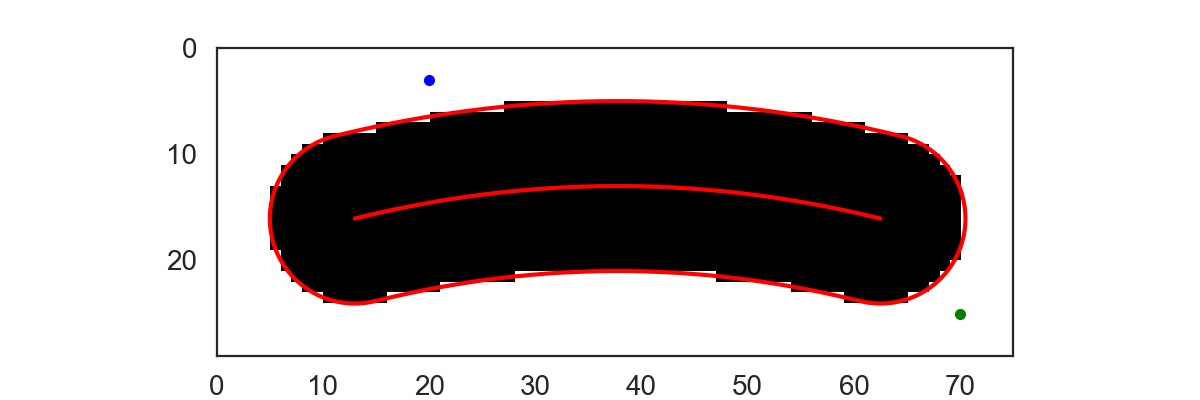

In [8]:
plt.figure(figsize=(6,2))
cp_1.imshow('binary')
cp_1.plot_outline()
cp_1.plot_midline()
plt.plot(*p1, 'b.')
plt.plot(*p2, 'g.')

To transform the coordinates to cell coordiantes the function `Cell.coords.transform(x, y)` can be called. In the line below the asterix (\*) is used to unpack the coordinate pair tuple:

In [5]:
cell_1.coords.transform(*p1)

(8.981099992419189, 11.41476377161665, 0.0)

The returned values are $l_c$, $r_c$ and $\phi$, respectively. The first coordinate ($l_c$) is the coordinate of `p1` along the length of the cell. The second coordinate ($r_c$) is the distance from the midline to the point `p1`. The third coordinate ($\phi$) describes the angle with respect to a line perpendicular to the cell's mideline. This is given in degrees and is defined to be 0 a the top, running from 0 to 180 along the right pole, 180 below the midline, and from 180 back to 0 along the left pole.

We can check the result by tranforming the coordinates back using the same cell's coordinate system:

In [11]:
l, r, phi = cell_1.coords.transform(*p1)
cell_1.coords.rev_transform(l, r, phi, l_norm=False)

(19.99999999999999, 3.0000000000000018)

We can see we get the original coordinates back (within a factor of $~10^{-16}$ of a pixel, typically on the order of yoctometers)). The `l_norm` keyword argument indicates that the input $l_c$ coordinate is in absolute units rather than a fraction of the total length of the cell.

The second point transforms in a similar fashion:

In [17]:
cell_1.coords.transform(*p2)

(50.000000000000014, 11.667776499545694, 126.09313884379844)

In [18]:
l, r, phi = cell_1.coords.transform(*p2)
cell_1.coords.rev_transform(l, r, phi, l_norm=False)

(70.0, 24.999999999999996)

We can also transform the points back onto another cell. For this we'll generate a differently shaped cell:

In [19]:
cell_2 = SynthCell(30, 7, -0.0025)
cp_2 = CellPlot(cell_2)

The cartesian coordinates are transformed to cell coordinates using the coordinate system of cell 1, and then reverse transformed using the coordinate system of cell 2. Note that the input length coordinate is given as a fraction of the whole cell length. 

In [23]:
l, r, phi = cell_1.coords.transform(*p1)
p1_t = cell_2.coords.rev_transform(l/cell_1.length, r, phi)

l, r, phi = cell_1.coords.transform(*p2)
p2_t = cell_2.coords.rev_transform(l/cell_1.length, r, phi)

We can use these result to plot the points `p1` and `p2` as if they where measured for a cell with the shape of cell 2.

<IPython.core.display.Javascript object>


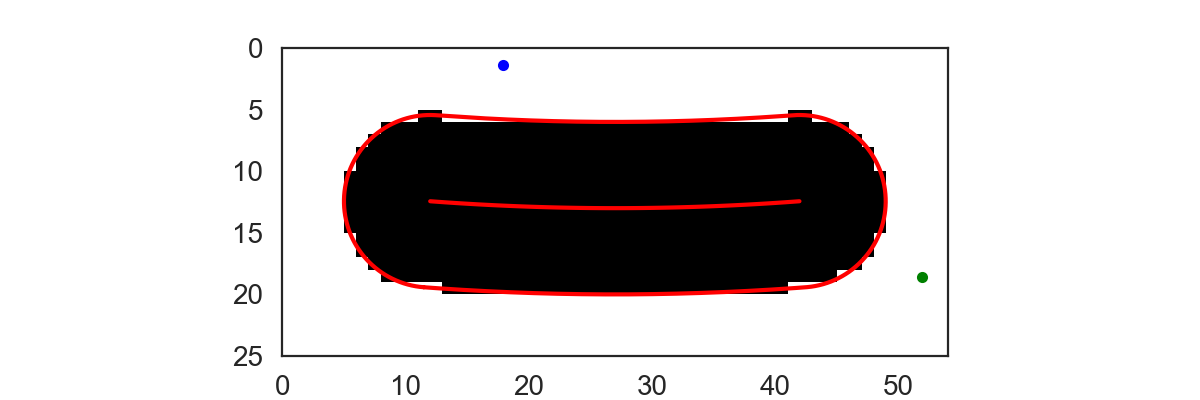

In [24]:
plt.figure(figsize=(6,2))
cp_2.imshow('binary')
cp_2.plot_outline()
cp_2.plot_midline()
plt.plot(*p1_t, 'b.')
plt.plot(*p2_t, 'g.')

## Cell Alignment

In this second part of the tutorial we will transform first the fluorescence channel and second storm localizations from many differently shaped cells to one model cell. We will load a set of 50 cell with previously generated fluorescence images and storm localizations.

In [4]:
cell_list = load('data/03_synthetic_cells.hdf5')

To explore this data set the radial distribution of the fluorescence and storm data elements are plotted, as well as a histgram of both length and radius. This particular dataset features a fluorecence channel with a signal mostly from the cell's membrane as well a set of STORM-type localizations homogenously distributed on the membrane.

<IPython.core.display.Javascript object>


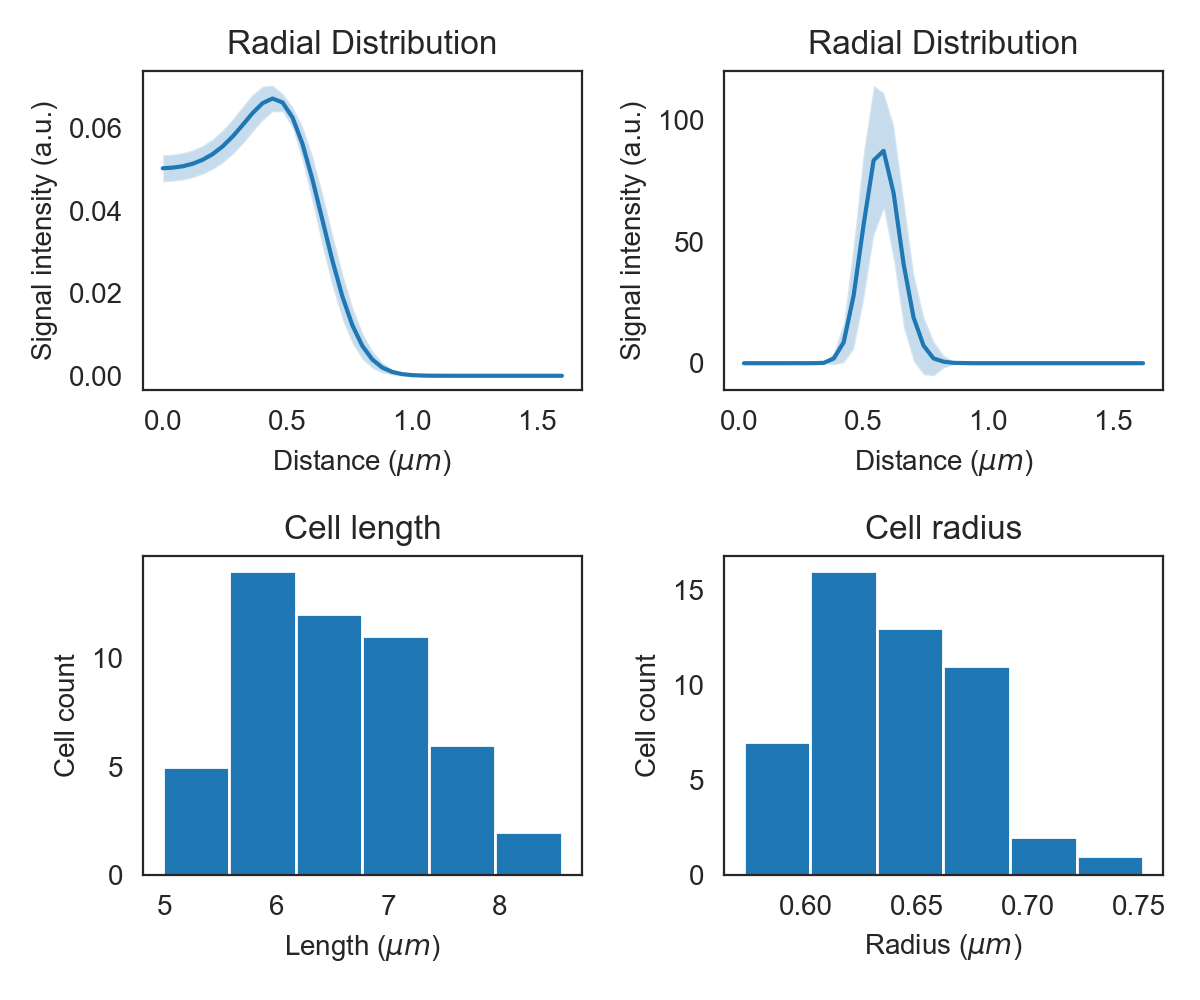

In [14]:
clp = CellListPlot(cell_list)
fig, axes = plt.subplots(2, 2, figsize=(6, 5))
clp.plot_r_dist(data_name='fluorescence', ax=axes[0, 0])
clp.plot_r_dist(data_name='storm', method='box', ax=axes[0, 1])
clp.hist_property('length', ax=axes[1, 0])
clp.hist_property('radius', ax=axes[1, 1])
plt.tight_layout()

We can look at one individual cell for some more detail. As can been seen from the image the cells in this dataset also have a bit of curvature. We can quantify this by looking at the second-degree coefficient.

<IPython.core.display.Javascript object>


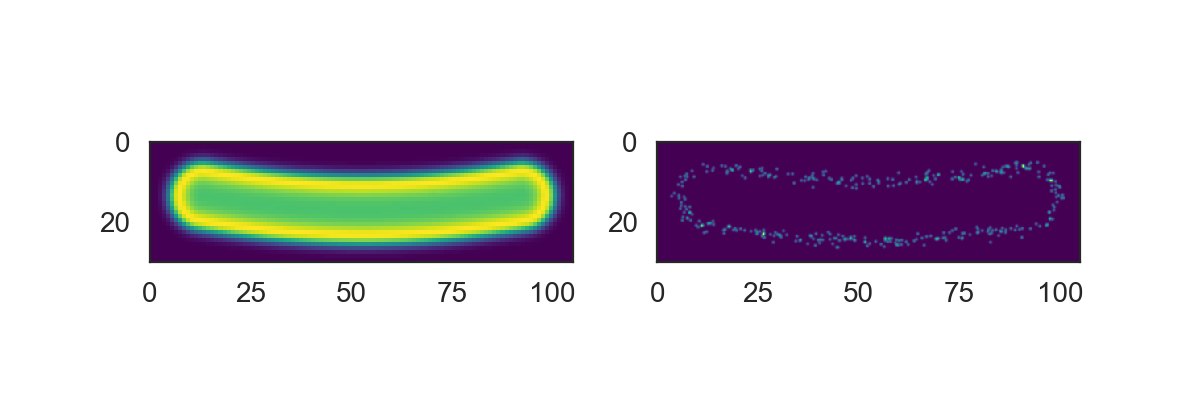

In [17]:
cp = CellPlot(cell_list[0])
fig, axes = plt.subplots(1, 2, figsize=(6, 2))
cp.imshow('fluorescence', ax=axes[0])
cp.plot_storm(method='gauss', ax=axes[1])

In [15]:
model_cell = SynthCell(40, 8, 1e-5)

<IPython.core.display.Javascript object>


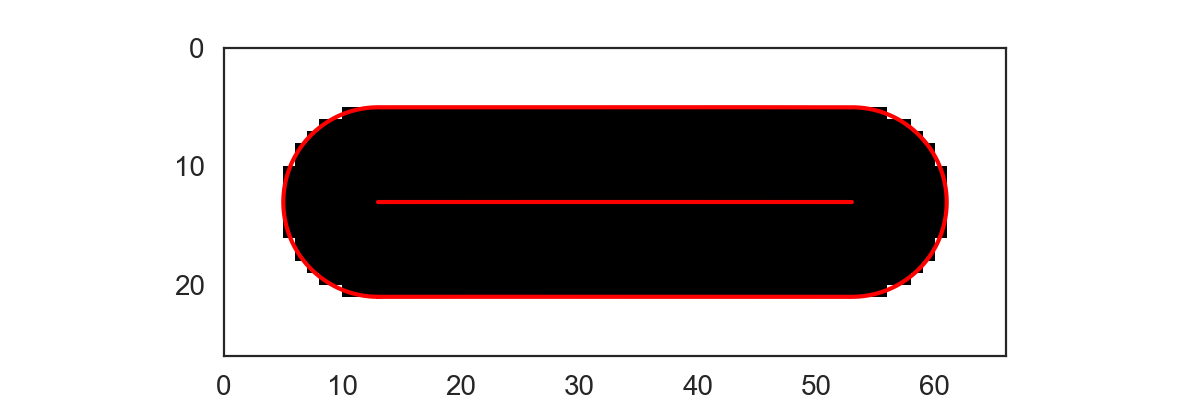

In [16]:
cp_m = CellPlot(model_cell)
plt.figure(figsize=(6,2))
cp_m.imshow('binary')
cp_m.plot_outline()
cp_m.plot_midline()

To illustrate the process, we will first map the position of all pixels in on cell of the dataset to our model cell. We use the attributes `Cell.coords.lc`, `Cell.coords.rc`, `Cell.coords.phi` which are contain the cell coordinates for all pixels in the image. The length coordinates are again divided by the cell's length to normalize it.

In [10]:
cell_0 = cell_list[0]
x, y = model_cell.coords.rev_transform(cell_0.coords.lc / cell_0.length, cell_0.coords.rc, cell_0.coords.phi)

<IPython.core.display.Javascript object>


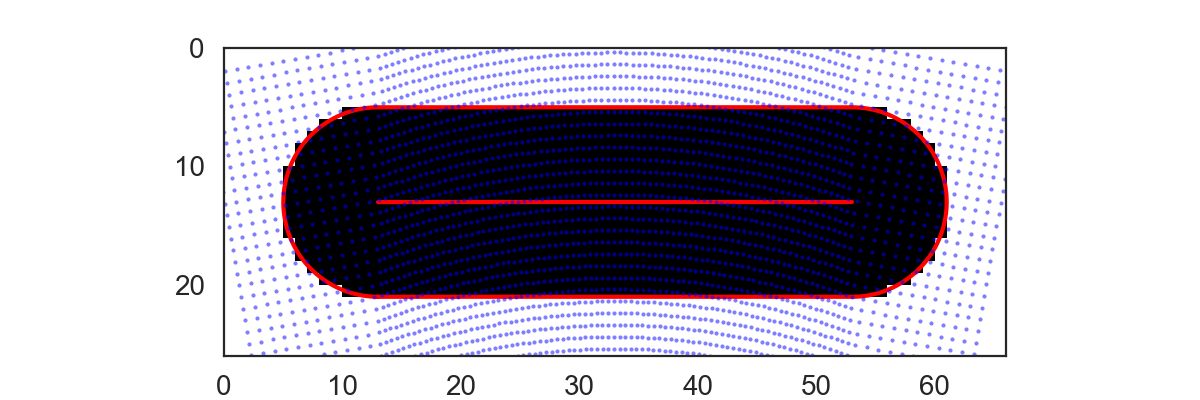

In [11]:
cp_m = CellPlot(model_cell)
plt.figure(figsize=(6,2))
cp_m.imshow('binary')
cp_m.plot_outline()
cp_m.plot_midline()
plt.plot(x.flatten(), y.flatten(), 'b.', alpha=0.5, markersize=1)

In [12]:
img = align_cells(model_cell, cell_list, 'fluorescence', r_norm=True, sigma=1)

<IPython.core.display.Javascript object>


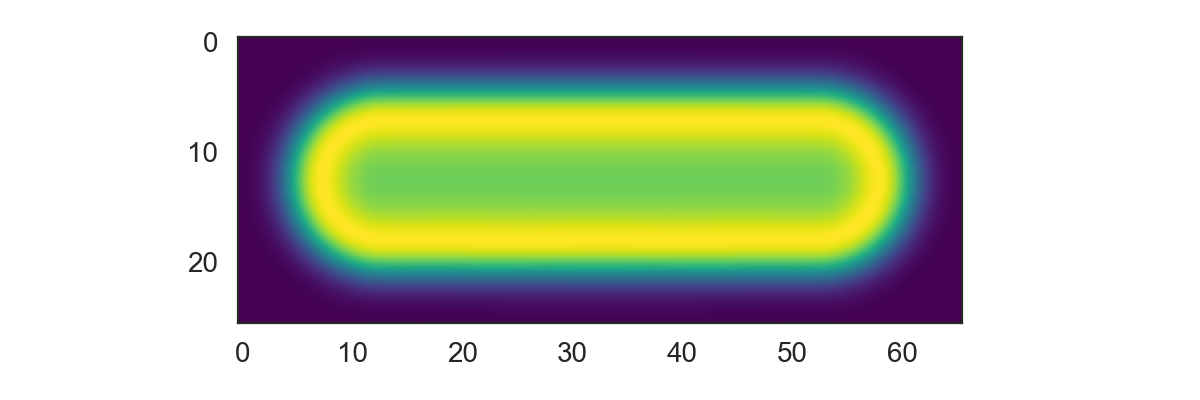

In [101]:
plt.figure(figsize=(6,2))
plt.imshow(img, interpolation='spline16', cmap='viridis')
plt.tight_layout()

In [44]:
from colicoords import RDistModel, PSF
from tqdm import tqdm_notebook
from colicoords import CellListPlot, save, load

In [39]:
cell_list = SynthCellList(lengths, radii, curvatures)
psf = PSF(1.54)
rmodel = RDistModel(psf)
for cell in tqdm_notebook(cell_list):
    a2 = np.random.normal(0.85, 0.07)
    a1 = 1 - a2
    r1 = cell.coords.r
    r2 = 0.9*cell.coords.r
    par_dict = {'a1':a1, 'a2':a2, 'r1':r1, 'r2':r2}
    rmodel.sub_par(par_dict)
    
    cell.add_radial_model_data(rmodel, num=100)

c:\users\smit\pycharmprojects\colicoords\colicoords\models.py:29: RuntimeWarning: invalid value encountered in sqrt
  return psf(x - v) * np.nan_to_num(np.sqrt(r1 ** 2 - x ** 2))


c:\users\smit\pycharmprojects\colicoords\colicoords\models.py:38: RuntimeWarning: invalid value encountered in sqrt
  return psf(x - v) * np.nan_to_num(np.sqrt(1 + (x ** 2 / (r2 ** 2 - x ** 2))))
C:\Miniconda3\envs\py_main\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [42]:
clp = CellListPlot(cell_list)

In [47]:
save('temp_cl.hdf5', cell_list)

<IPython.core.display.Javascript object>


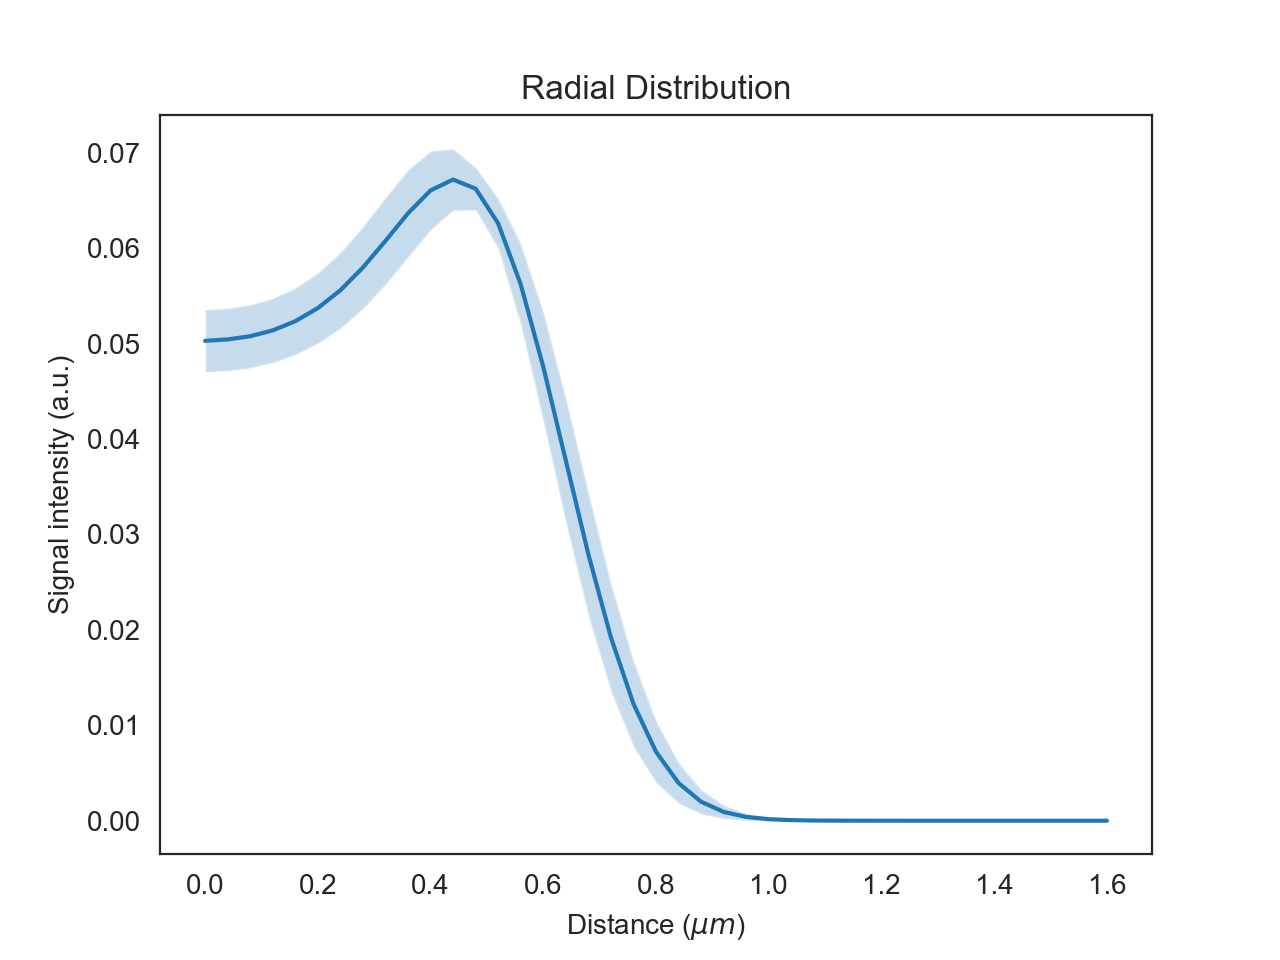

In [43]:
plt.figure()
clp.plot_r_dist()

In [49]:
0.1*cell.coords.r

0.7703141605005729

In [51]:
cl_bak = cell_list

In [53]:
cell_list = cl_bak

In [54]:
cl1 = load('temp_cl.hdf5')
for cell in tqdm_notebook(cell_list):
    num = int(np.random.normal(400, 100))
    cell.add_storm_membrane(num, 0.9*cell.coords.r, r_std=0.1*cell.coords.r)

[23.4142948  76.62044068 23.4142948  81.89341589]
False
False
<class 'numpy.float64'>
76.62044067637976
total 205.34244616859712 372
[26.56470851 91.45804285 26.56470851 81.4388858 ]
False
False
<class 'numpy.float64'>
91.45804284685634
total 226.02634567029367 521
[21.34305469 93.45265681 21.34305469 84.75503809]
False
False
<class 'numpy.float64'>
93.45265681116662
total 220.89380428180323 494
[22.62420915 86.17557245 22.62420915 88.05534527]
False
False
<class 'numpy.float64'>
86.17557244679664
total 219.47933601335956 192
[23.03975662 70.77577474 23.03975662 73.06800538]
False
False
<class 'numpy.float64'>
70.7757747431416
total 189.92329336432408 410
[23.21946153 92.95933399 23.21946153 84.87190556]
False
False
<class 'numpy.float64'>
92.95933399136803
total 224.2701626086651 478
[22.88959927 85.34276698 22.88959927 95.53337105]
False
False
<class 'numpy.float64'>
85.34276697778547
total 226.6553365747393 390
[22.24432849 60.46176209 22.24432849 73.51473328]
False
False
<class 'nu

In [33]:
np.random.normal(0.85, 0.07)

0.9210674294106193

<IPython.core.display.Javascript object>


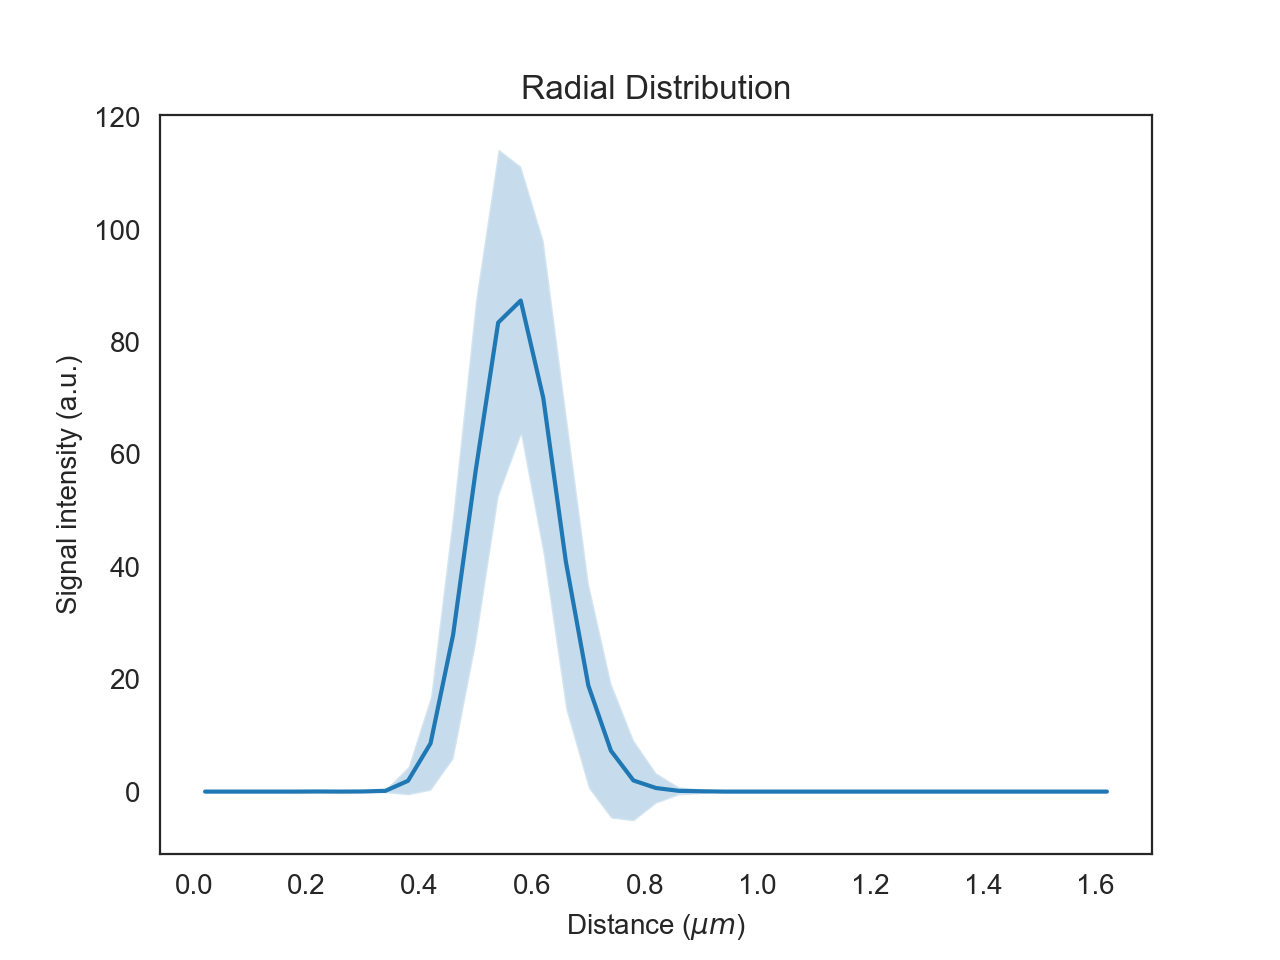

In [58]:
plt.figure()
clp.plot_r_dist(data_name='storm', method='box')

In [59]:
save('cells_final.hdf5', cell_list)